# Проект: классификация

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import re

### Часть 1. Я буду обрабатывать пропуски и выбросы в данных

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.isna().sum() #узнаем в каких признаков пропущенны значания и их количество

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

##### Bозможно вместо пропусков имеются закодированые слова. Проверим на признаке 'job"

In [7]:
print(df['job'].value_counts()) 

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64


##### Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.
##### Для начала обработаем 'balance', там имеется знак доллара и запятая. Преобразуем в float

In [5]:
# создам функцию convert и с помощью replace уберу ненужные символы и верну в тип float
def convert(row):
    row = str(row) 
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace(' ', '')
        row = row.replace('$', '')
        return float(row)
    else:
        return np.nan
    
df['balance'] = df['balance'].apply(convert)
round(df['balance'].mean(),3) #найду среднее значение с пропусками

1529.129

##### Теперь обработую пропуски медианной и потом найду среднее

In [6]:
df= df.fillna( {'balance': df['balance'].median()}) 
round(df['balance'].mean(),3) 

1526.936

##### Теперь заменю кодированное слово "unknown" самой частой должностью (модой)

In [7]:
df['job'] = df['job'].replace(['unknown'],'management')
df['education'] = df['education'].replace(['unknown'],'secondary')

##### Найду среднее значение с самой популярной работой и с самым популярным образованием

In [8]:
df_mean = df[((df['job'] == 'management') & (df['education'] == 'secondary'))] 
round(df_mean['balance'].mean(),3)

1598.883

##### С помощью функции найду верхнюю и нижнюю границу, количество выбросов через Тьюки и число записей в границах

In [9]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print(f'Верхняя и нижняя граница: {upper_bound, lower_bound}')
    outliers = data[(x<=lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Верхняя и нижняя граница: (4063.0, -2241.0)
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


##### Удалю все выборсы

In [10]:
outliers = df[(df['balance'] > 4063.0) | (df['balance'] < -2241.0)]
df = df.drop(outliers.index)

##### Другой способ найти выбросы

In [11]:
#array = np.percentile(df['balance'], [25,75])
#df_q = pd.DataFrame(array)
#data=df
#x = df_copy['balance']
#quartile_1 = df_q[0][0]
#quartile_3 = df_q[0][1]
#iqr = quartile_3 - quartile_1
#lower_bound = quartile_1 - (iqr * 1.5)
#upper_bound = quartile_3 + (iqr * 1.5)
#outliers = data[(x<=lower_bound) | (x >= upper_bound)]
#cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
#print(f'Нижний квартиль, найденный с помощью функции percenile() (25): {quartile_1}')
#print(f'Верхний квартиль, найденный с помощью функции percenile() (25): {quartile_3}')
#print(f'Нижняя граница выбросов: {round(lower_bound)}')
#print(f'Верхняя граница выбросов: {round(upper_bound)}')
#print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
#print(f'Результирующее число записей: {cleaned.shape[0]}')

### Часть 2. В данной части  буду исследовать данные, попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;

##### Узнаю сколько клиентов открыли депозит

no     5424
yes    4681
Name: deposit, dtype: int64


<AxesSubplot:xlabel='deposit', ylabel='count'>

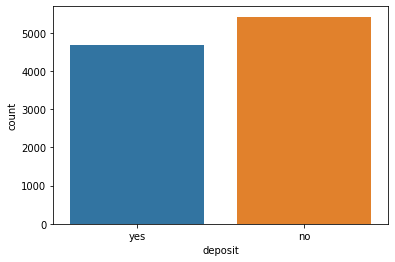

In [12]:
print(df['deposit'].value_counts())
sns.countplot(data=df, x='deposit')

##### Узнаю макс. возраст клиента и минимальную длительность разговора

In [13]:
print(df['age'].max())
print(df['duration'].min())

95
2


##### Узнаю больше информации о типах "object" 

In [14]:
df.describe(include='object')


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


##### Узнаю больше о сферах занятости

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64


<AxesSubplot:xlabel='job', ylabel='count'>

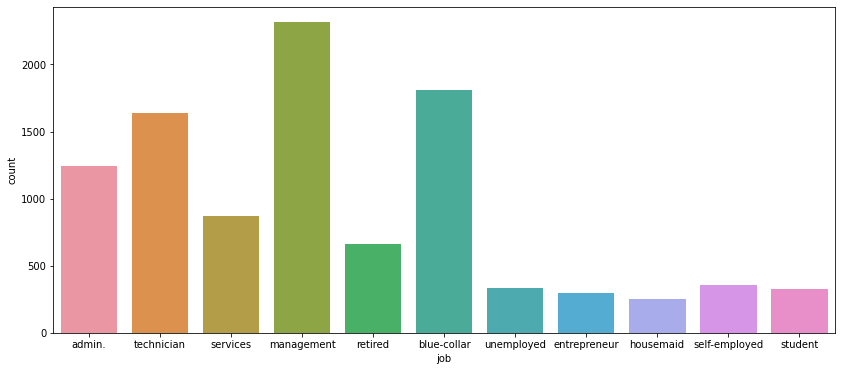

In [15]:
print(df['job'].value_counts())
fig = plt.figure(figsize=(14,6))
sns.countplot(data=df, x='job')

##### Узнаю больше о статусе маркетинговой компании

In [16]:
df['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

##### Рассчитаю, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. 

In [17]:
mask0 = df[df['deposit'] == 'no'].groupby('month')['deposit'].count() #создаем условие, что deposit=='no', а потом группируем таблицу по месяцам для депозита
mask1 = df.groupby('month')['deposit'].count() # группируем таблицу по месяцам для депозита
#создаем новый датафрейм, где deposit_no- отказавшиеся в открытии депозита ,counter- общее количество согласившихся и отказавшиеся в открытии депозита
df_month = pd.DataFrame({'deposit_no': mask0, 'counter': mask1}) 
#создаем новый признак, где % percentage- процентное соотношение и округляем до сотых
df_month['% percentage'] = round((df_month['deposit_no']/df_month['counter'])*100, 2)
df_month.sort_values(by='% percentage')

,deposit_no,counter,% percentage
month,,,
dec,9,93,9.68
mar,24,237,10.13
sep,46,278,16.55
oct,62,335,18.51
apr,317,830,38.19
feb,323,709,45.56
jun,606,1104,54.89
aug,775,1385,55.96
nov,456,780,58.46


##### Создам возрастные группы и узнаю, в каком возрасте более склоны открывать депозит

In [20]:
def group_age(arg):
    age_age = ['<=30', '31-40', '41-50', '51-60', '60+']    
    
    if arg<30:
        return '<=30'
    elif arg >= 30 and arg <= 40:
        return '31-40'
    elif arg >= 41 and arg <= 50:
        return '41-50'
    elif arg >= 51 and arg <= 60:
        return '51-60'
    else:
        return '60+'

df['age_groups'] = df['age'].apply(group_age)     

In [21]:
df[df['deposit'] == 'yes'].groupby('age_groups')['deposit'].count()

age_groups
31-40    1817
41-50     895
51-60     692
60+       416
<=30      861
Name: deposit, dtype: int64

In [22]:
df.groupby('age_groups')['deposit'].count()

age_groups
31-40    4257
41-50    2255
51-60    1625
60+       513
<=30     1455
Name: deposit, dtype: int64

##### Узнаю какой сфере занято наибольшее число клиентов банка

In [23]:
df['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

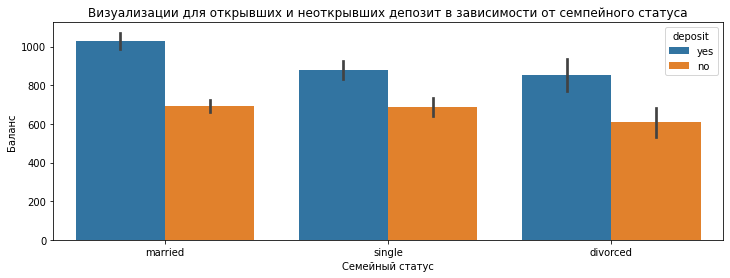

In [24]:
# визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(12,4))
barplot = sns.barplot(data=df, x="marital", y='balance',hue="deposit")
barplot.set_title('Визуализации для открывших и неоткрывших депозит в зависимости от семпейного статуса');
barplot.set_xlabel('Семейный статус');
barplot.set_ylabel('Баланс');

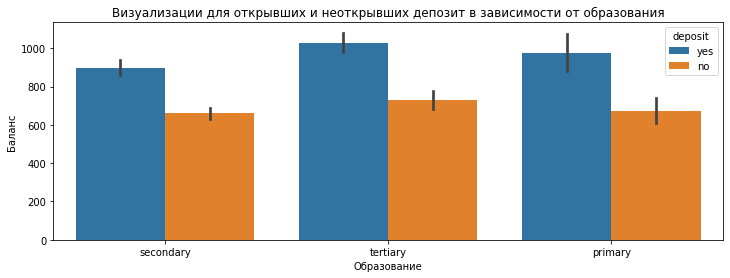

In [25]:
#визуализация для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(12,4))
barplot = sns.barplot(data=df, x="education", y= 'balance',hue="deposit")
barplot.set_title('Визуализации для открывших и неоткрывших депозит в зависимости от образования');
barplot.set_xlabel('Образование');
barplot.set_ylabel('Баланс');

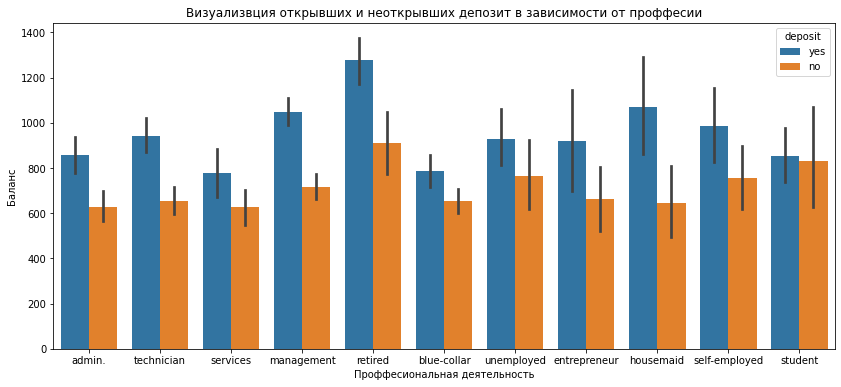

In [26]:
# визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(14,6))
barplot = sns.barplot(data=df, x="job", y= 'balance',hue="deposit")
barplot.set_title('Визуализвция открывших и неоткрывших депозит в зависимости от проффесии');
barplot.set_xlabel('Проффесиональная деятельность');
barplot.set_ylabel('Баланс');


##### Построю сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны 

In [28]:
deposit_no = df[df['deposit'] == 'no']
deposit_no.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


In [29]:
deposit_yes = df[df['deposit'] == 'yes']
deposit_yes.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


## Часть 3: преобразование данных

##### С помощью LabelEncoder обработаю признак education

In [30]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['education'].sum()


11995

##### Преобразую deposit в бинарный и посмотр всю необходимую информацию

In [32]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['deposit'].describe()


count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

##### Также преобразую все другие признаки в бинарный, где имеется Да или Нет

In [33]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)


In [34]:
df['default'].mean() + df['housing'].mean() + df['loan'].mean()

0.6354280059376547

##### Теперь перекодирую  все остальные признаки в dummy-переменные и добавлю в датасет

In [35]:
df_job = pd.get_dummies(df['job'], prefix='job')
df_marital = pd.get_dummies(df['marital'], prefix='marital')
df_contact = pd.get_dummies(df['contact'], prefix='contact')
df_month = pd.get_dummies(df['month'], prefix='month')
df_poutcome = pd.get_dummies(df['poutcome'], prefix='poutcome')
df = pd.concat([df, df_job, df_marital, df_contact, df_month, df_poutcome], axis=1)
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


In [36]:
df = df.drop(['job','marital','contact','month', 'poutcome'], axis=1) #удаляю преобразлованные признака 

##### Узнаю коррелирующие значени данных признаков

In [37]:
onne = np.corrcoef(df['deposit'], df['poutcome_success'])
twoo = np.corrcoef(df['deposit'], df['duration'])
free = np.corrcoef(df['deposit'], df['contact_cellular'])
print(onne)
print(twoo)
print(free)


[[1.         0.28849098]
 [0.28849098 1.        ]]
[[1.         0.45781769]
 [0.45781769 1.        ]]
[[1.         0.22394445]
 [0.22394445 1.        ]]


##### Посмотрю корреляцию всех остальных признаков

<AxesSubplot:>

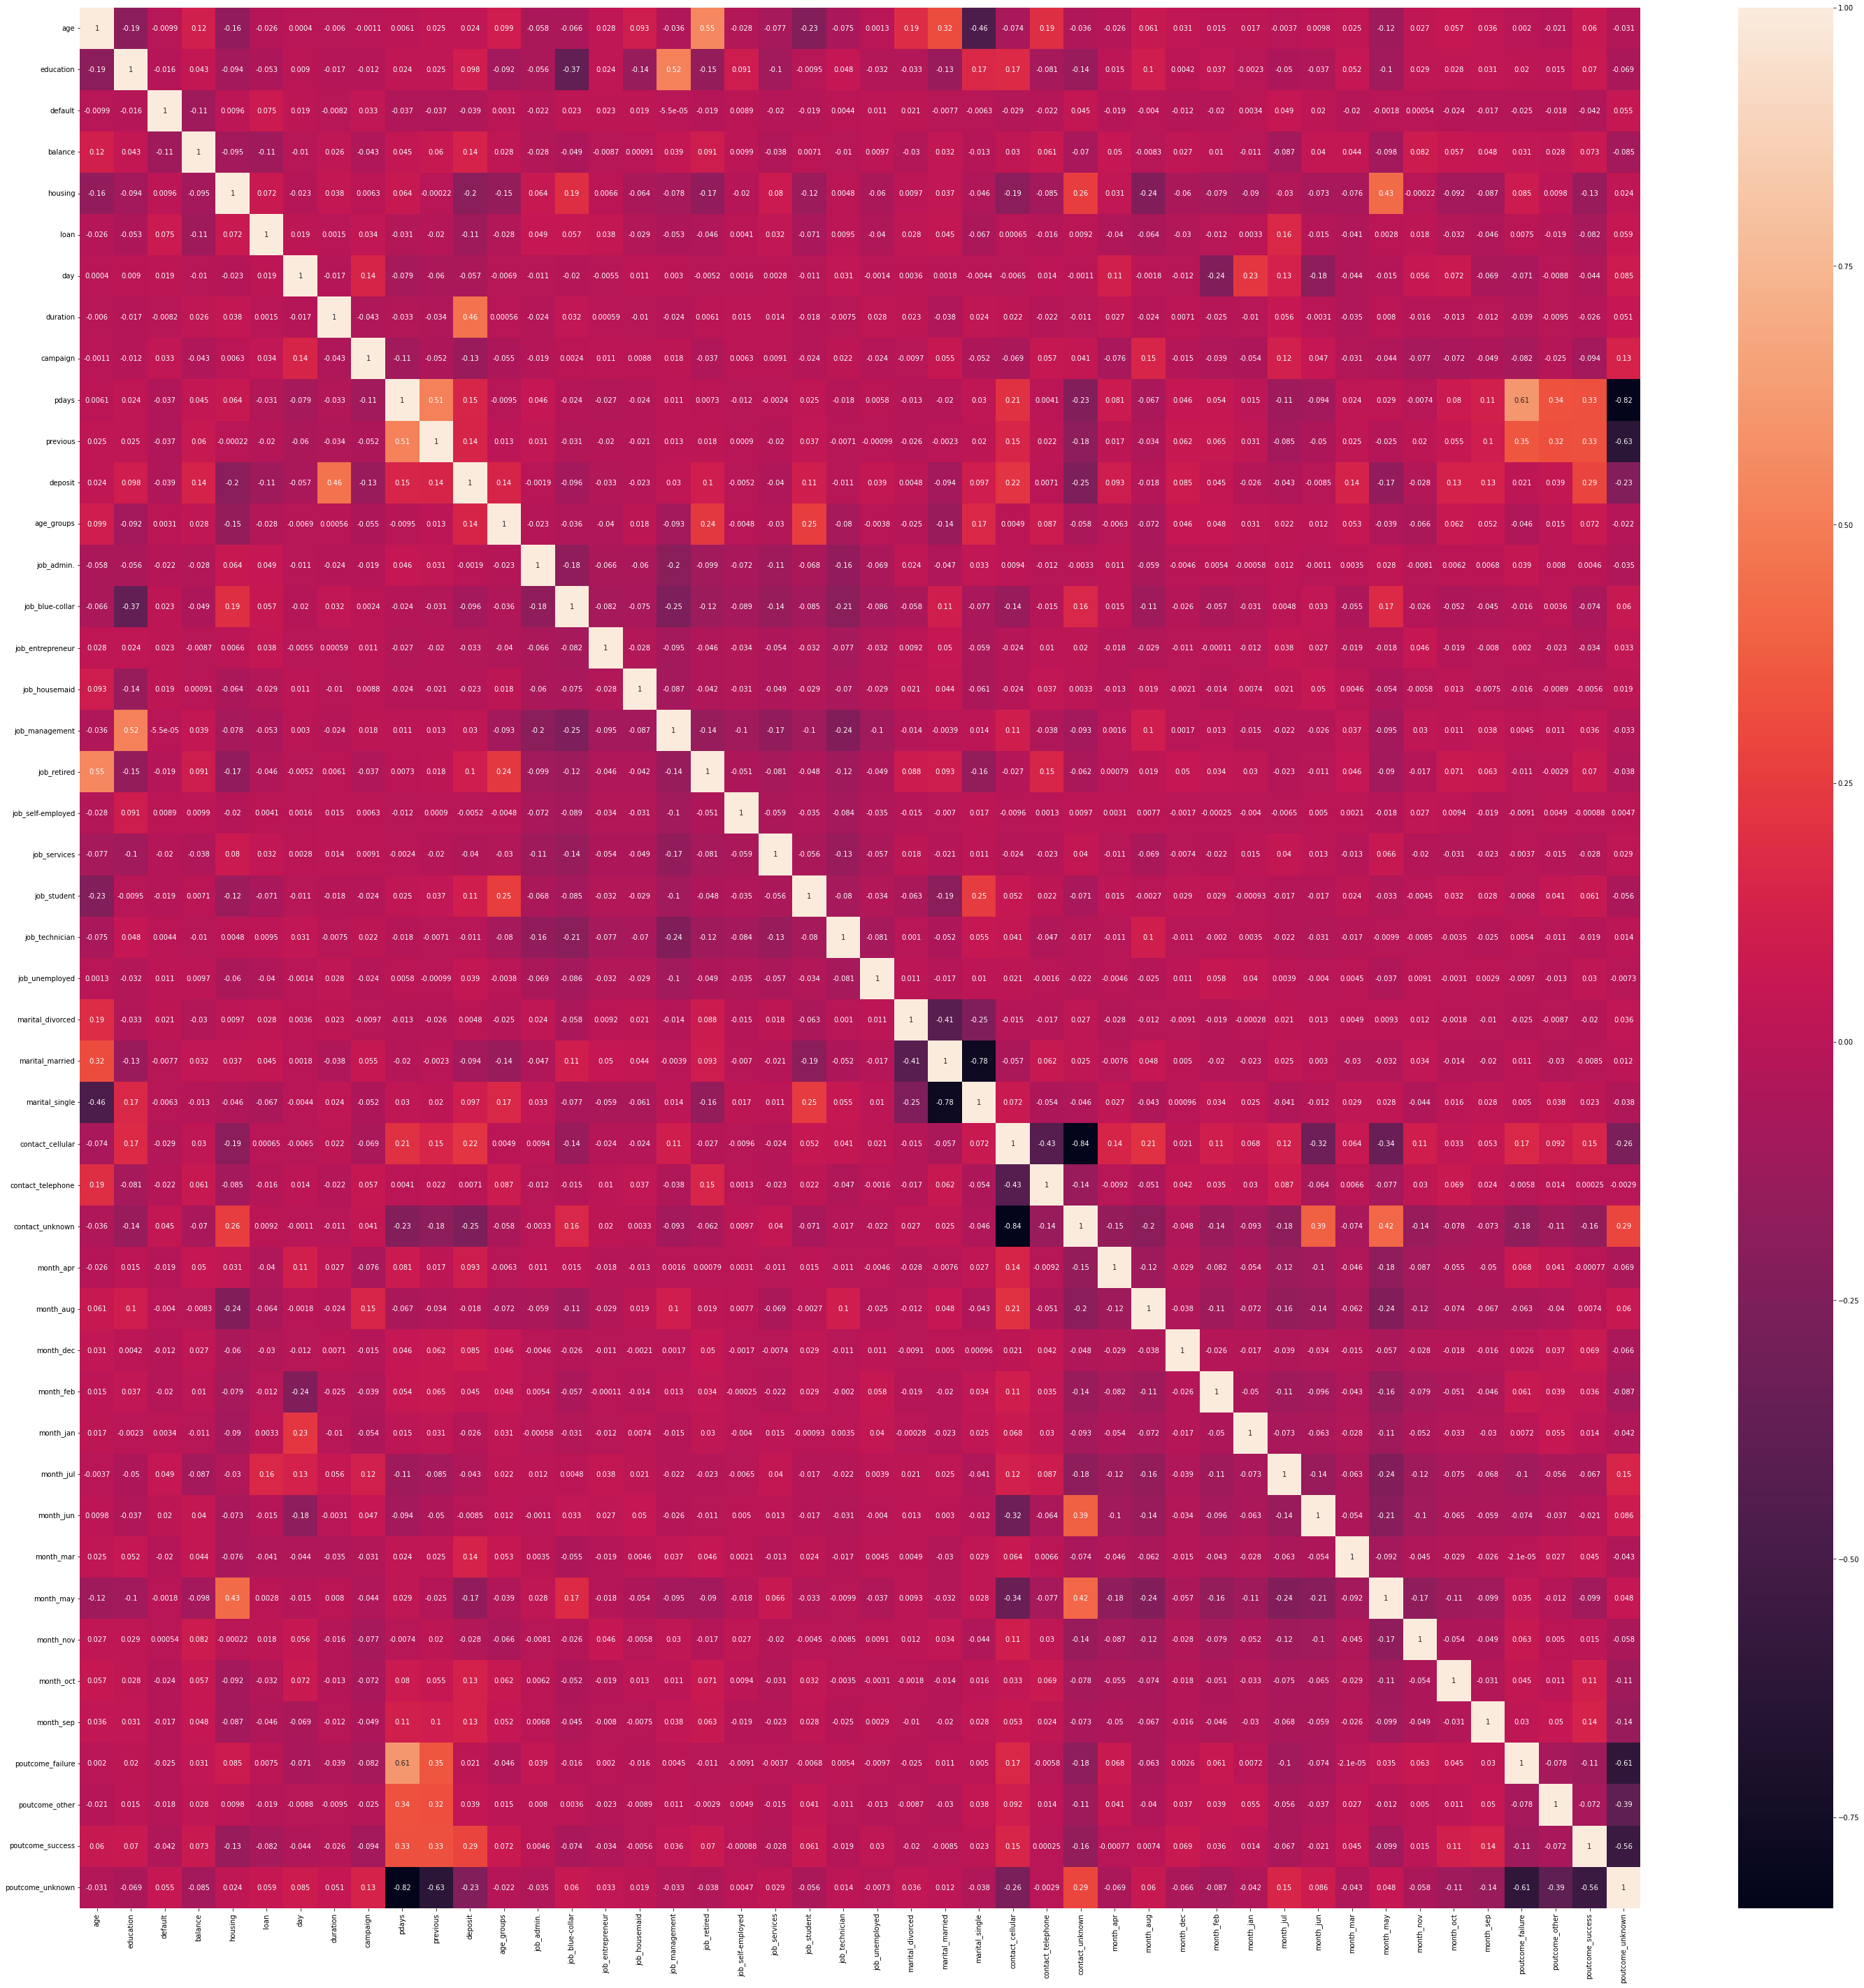

In [38]:
fig = plt.figure(figsize=(50,50))
sns.heatmap(df.corr(), annot=True)

##### Разделю датасет на тренировочные и тестовые выборки в 0.33 и узнаю размерномть

In [39]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [40]:
print(X_test.shape)
print(y_test.mean())

(3335, 45)
0.46326836581709147


##### С помощью SelectKBest, найду 15 наиболеее важных признков для обучения

In [41]:
skb = SelectKBest(score_func=f_classif, k=15)
skb.fit(X_train, y_train)
skb.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [42]:
y_test.shape

(3335,)

##### Обновлю датесет из 15 наиболее важных признаков и разделю их на тестовые и тренировочные. После этого нормализую их с помощью MinMaxScaler

In [43]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_groups', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [44]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
mm_scaler.transform(X_train)
mm_scaler.transform(X_test)
round(mm_scaler.transform(X_train)[:,0].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

##### Обучу логистическую регрессию и рассчитаю метрики

In [61]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn.linear_model import LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X,y)
y_pred1 = log_reg.predict(X_train)
y_pred2 = log_reg.predict(X_test)

print('Достверность тренировочной выборки: {:.2f}'.format(metrics.accuracy_score(y_pred1, y_train)))
print('Достверность тестовой выборки: {:.2f}'.format(metrics.accuracy_score(y_pred2, y_test)))


Достверность тренировочной выборки: 0.83
Достверность тестовой выборки: 0.81


##### Обучу деревья решений и рассчитаю метрики

In [48]:
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=6,
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train, y_train)
clf1 = dt_clf.predict(X_train)
clf2 = dt_clf.predict(X_test)
print('Достверность тренировочной выборки: {:.2f}'.format(metrics.accuracy_score(clf1, y_train)))
print('Достверность тестовой выборки: {:.2f}'.format(metrics.accuracy_score(clf2, y_test)))


Достверность тренировочной выборки: 0.82
Достверность тестовой выборки: 0.81


##### С помощью GridSearch подберу нужные гиперпараметры для улучшения метрик

In [52]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

perameters = {'min_samples_split': [2, 5, 7, 10], 
              'max_depth':[3,5,7]}

grid_search = GridSearchCV(
    estimator= tree.DecisionTreeClassifier(),
    param_grid=perameters,
    cv=5, 
    n_jobs=-1,
    return_train_score=True)

grid_search.fit(X_train, y_train)
GsCV1 = grid_search.predict(X_train)
GsCV2 = grid_search.predict(X_test)
print('F1 тренировочной выборки: {:.2f}'.format(metrics.f1_score(GsCV1, y_train)))
print('F1 тестовой выборки: {:.2f}'.format(metrics.f1_score(GsCV2, y_test)))

F1 тренировочной выборки: 0.82
F1 тестовой выборки: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [59]:

rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf=5,
    max_depth=10, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X, y)
 
#Делаем предсказание класса
y_predictor = rf_clf_2d.predict(X)
#Выводим отчёт о метриках
print(metrics.accuracy_score(y, y_predictor))
print(metrics.recall_score(y, y_predictor))
print(metrics.f1_score(y, y_predictor))

0.8511627906976744
0.8613544114505448
0.842809364548495


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
learning_rate=0.05,
max_depth=5, #максимальная глубина дерева
n_estimators=300, #количество деревьев
min_samples_leaf=5,
random_state=42 #генератор случайных чисел
)

gb.fit(X, y)
gb_pred = gb.predict(X)
print(metrics.f1_score(y, gb_pred))
